# Imputación multivariada

En esta lección veremos cómo usar la información de múltiples variables para completar los datos faltantes en una Serie de Tiempo, lo que se conoce precisamente como imputación multivariada.

En particular veremos los dos métodos más usados:

- Imputación con modelos de regresión de Machine Learning: usada cuando el dataset contiene múltiples variables y una de ellas contiene datos faltantes. En este caso podemos usar *IterativeImputer* de Scikit-Learn
- Imputación MICE (*Multiple Imputation by Chained Equations*): usada cuando el dataset contiene múltiples variables y a la vez varias de ellas contienen datos faltantes. En este caso podemos usar *MICE* de la librería "statsmodels".

Al final veremos por qué son métodos más robustos que los métodos de imputación univariada vistos en la lección anterior y de igual forma veremos las situaciones en las que se sugiere usarlos.

## 1. Función auxiliar

Comencemos re-creando la función `graficar_serie` usada en una lección anterior:

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def graficar_serie(df, obs='', titulo=''):
    '''
    Permite graficar la Serie de Tiempo y mostrar simultáneamente
    sus valores extremos.
    
    Parámetros:
    - df: DataFrame de Pandas con la(s) Serie(s) de Tiempo
    - obs: nombre de la columna a graficar
    '''
    # Gráfico vacío
    fig, ax = plt.subplots(1,1)
    
    # Gráfico inicial
    if type(df) == pd.DataFrame:
        ax = sns.pointplot(data=df, x=df.index, y=obs, markers='')
    else:
        # Convertir Serie de Pandas a DataFrame de Pandas y graficar
        df = df.to_frame(name=obs) 
        ax = sns.pointplot(data=df, x=df.index, y=obs, markers='')
    
    # Dibujar sólo N=10 marcas temporales (en caso de tener series de tiempo)
    # con demasiadas marcas
    n_ticks = 10
    locator = mdates.AutoDateLocator(maxticks=n_ticks)
      

    # Apply the locator and formatter to the x-axis
    ax.xaxis.set_major_locator(locator)
   
        
    # Rotar los ticks 45°
    plt.xticks(rotation=45)
    
    # Etiquetas ejes horizontal y vertical
    plt.xlabel('Tiempo')
    plt.ylabel(obs)
    plt.title(titulo)

## 2. El set de datos

En este caso usaremos el set *clicks_obs_faltantes.csv* que contiene información de interacción de usuarios (número de clicks) de un sitio web de artículos de vestuario.

Comencemos leyendo y mostrando el set de datos:

C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_11232\3243142474.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  clicks_df = pd.read_csv(RUTA + 'clicks_obs_faltantes.csv',


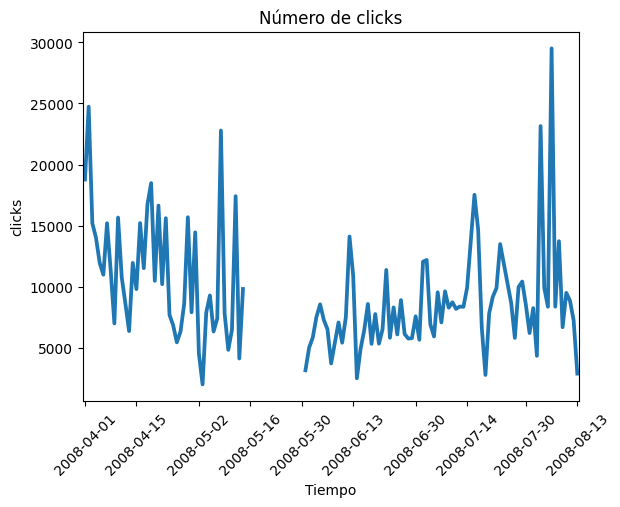

In [4]:
import pandas as pd

# Leer dataset co2_faltantes.csv
RUTA = '../datasets/missing_values/'

clicks_df = pd.read_csv(RUTA + 'clicks_obs_faltantes.csv',
                       parse_dates = ['fecha'],
                       index_col = ['fecha'])
graficar_serie(clicks_df, 'clicks', 'Número de clicks')

Antes de continuar debemos renombrar la columna "ubicación" a "ubicacion" (para evitar errores más adelante al momento de usar el algoritmo MICE):

In [5]:
clicks_df = clicks_df.rename(columns={'ubicación':'ubicacion'})
clicks_df

,precio,ubicacion,clicks
fecha,,,
2008-04-01,43.155647,2,18784.0
2008-04-02,43.079056,1,24738.0
2008-04-03,43.842609,2,15209.0
2008-04-04,43.312376,1,14018.0
2008-04-05,43.941176,1,11974.0
...,...,...,...
2008-08-09,44.182033,1,6716.0
2008-08-10,43.608260,1,9523.0
2008-08-11,43.553363,1,8881.0


## 3. Imputación con modelos de regresión de Machine Learning

La idea de este método es entrenar un modelo de Machine Learning que tome como entradas las variables que están completas y que aprenda a predecir la variable incompleta.

Es decir que se sugiere usar este método cuando tenemos sólo una variable incompleta y las demás no contienen valores faltantes.

La idea básica es la siguiente:

- Tomar los registros completos para entrenar un modelo de Machine Learning que aprenda a predecir la variable faltante.
- Usar el modelo entrenado para realizar la imputación

![](imputacion_multivariada_machine_learning.png)

La imputación es multivariada pues el modelo usará múltiples variables de entrada (las variables que están completas) para predecir la variable con los datos faltantes. Además, se trata de un **modelo de regresión** pues será entrenado para predecir una variable numérica.

En Machine Learning existe una amplia variedad de modelos de regresión, pero en este ejemplo en particular usaremos el más sencillo de todos: la regresión lineal.

Esto quiere decir que si la variable incompleta es por ejemplo $var_2$ y las variables completas son $var_1$ y $var_3$, entonces entrenaremos un modelo que usa un modelo lineal para generar las predicciones:

$$\bar{var_2} = \omega_1 var_1 + \omega_2 var_3 + b$$

donde:
- $\bar{var_2}$ es la predicción generada por el modelo
- $var_1$ y $var_3$ son las entradas al modelo
- $omega_1$, $omega_2$ y $b$ son los parámetros del modelo que se aprenden durante el entrenamiento a partir de los datos conocidos

Veamos cómo implementar esta imputación usando `IterativeImputer` de Scikit-Learn. Comencemos preparando el set de datos *clicks_df*:

In [6]:
clicks_df

,precio,ubicacion,clicks
fecha,,,
2008-04-01,43.155647,2,18784.0
2008-04-02,43.079056,1,24738.0
2008-04-03,43.842609,2,15209.0
2008-04-04,43.312376,1,14018.0
2008-04-05,43.941176,1,11974.0
...,...,...,...
2008-08-09,44.182033,1,6716.0
2008-08-10,43.608260,1,9523.0
2008-08-11,43.553363,1,8881.0


Comencemos verificando la cantidad de datos faltantes de cada variable (columna):

In [7]:
clicks_df.isna().sum()

precio        0
ubicacion     0
clicks       16
dtype: int64

Y con esto confirmamos que la columna "problemática" es *clicks*. Así que la idea es usar la imputación por regresión para completar la variable *clicks* con base en las variables *precio* y *ubicación* (que están completas).

Extraigamos estos datos como un arreglo de NumPy (requerido por Scikit-Learn):

In [9]:
clicks_vals = clicks_df.to_numpy()
clicks_vals

array([[4.31556468e+01, 2.00000000e+00, 1.87840000e+04],
       [4.30790558e+01, 1.00000000e+00, 2.47380000e+04],
       [4.38426092e+01, 2.00000000e+00, 1.52090000e+04],
       [4.33123759e+01, 1.00000000e+00, 1.40180000e+04],
       [4.39411765e+01, 1.00000000e+00, 1.19740000e+04],
       [4.44039363e+01, 1.00000000e+00, 1.10070000e+04],
       [4.39958876e+01, 2.00000000e+00, 1.52140000e+04],
       [4.33737734e+01, 1.00000000e+00, 1.13330000e+04],
       [4.33203125e+01, 1.00000000e+00, 7.02600000e+03],
       [4.31547376e+01, 5.00000000e+00, 1.56770000e+04],
       [4.29216590e+01, 2.00000000e+00, 1.07920000e+04],
       [4.27132075e+01, 1.00000000e+00, 8.64200000e+03],
       [4.35469337e+01, 1.00000000e+00, 6.40000000e+03],
       [4.44093473e+01, 1.00000000e+00, 1.19710000e+04],
       [4.22070175e+01, 1.00000000e+00, 9.83000000e+03],
       [4.31815603e+01, 2.00000000e+00, 1.52260000e+04],
       [4.40514925e+01, 1.00000000e+00, 1.15400000e+04],
       [4.23420875e+01, 1.00000

Ahora debemos importar los módulos requeridos de Scikit-Learn. Usaremos `IterativeImputer` y `LinearRegression`:

In [10]:
from sklearn.experimental import enable_iterative_imputer # Para poder importar "IterativeImputer"
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

Ahora creamos una instancia de "IterativeImputer" y definiendo como parámetro el estimador, que en este caso será una instancia del modelo de Regresión Lineal (`estimator = LinearRegression()`):

In [11]:
it_imp = IterativeImputer(
    estimator = LinearRegression())

Ahora entrenamos el modelo de regresión del imputador usando el método `fit()` y presentándole como argumento el set de datos (*clicks_vals*). En este caso Scikit-Learn automáticamente tomará los registros completos para entrenar el modelo:

In [12]:
it_imp.fit(clicks_vals)

IterativeImputer(estimator=LinearRegression())

Y por último, con el modelo entrenado, hacemos la imputación usando el método `transform()` y presentándole como argumento el set de datos (*clicks_vals*). En este caso Scikit-Learn automáticamente buscará e imputará los valores faltantes, que corresponden a la última columna generada.

Almacenemos este resultado en la columna *it_imp* del *DataFrame* original:

In [13]:
clicks_df['it_imp'] = it_imp.transform(clicks_vals)[:,2]
clicks_df

,precio,ubicacion,clicks,it_imp
fecha,,,,
2008-04-01,43.155647,2,18784.0,18784.0
2008-04-02,43.079056,1,24738.0,24738.0
2008-04-03,43.842609,2,15209.0,15209.0
2008-04-04,43.312376,1,14018.0,14018.0
2008-04-05,43.941176,1,11974.0,11974.0
...,...,...,...,...
2008-08-09,44.182033,1,6716.0,6716.0
2008-08-10,43.608260,1,9523.0,9523.0
2008-08-11,43.553363,1,8881.0,8881.0


Verifiquemos que los valores han sido imputados:

In [14]:
clicks_df.isna().sum()

precio        0
ubicacion     0
clicks       16
it_imp        0
dtype: int64

Y por último comparemos gráficamente la Serie de Tiempo antes y después de la imputación:

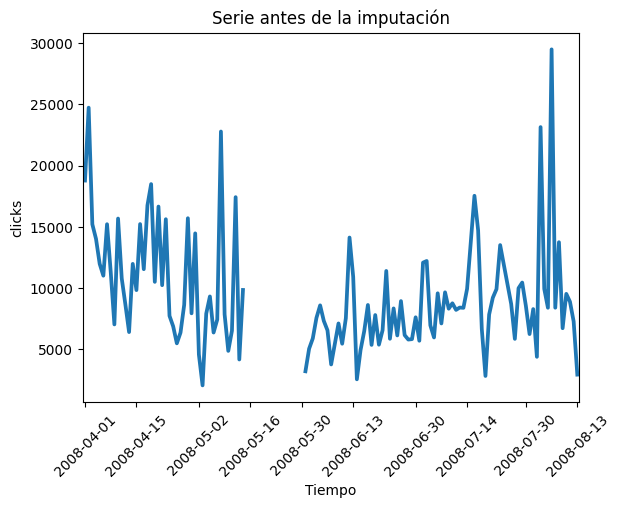

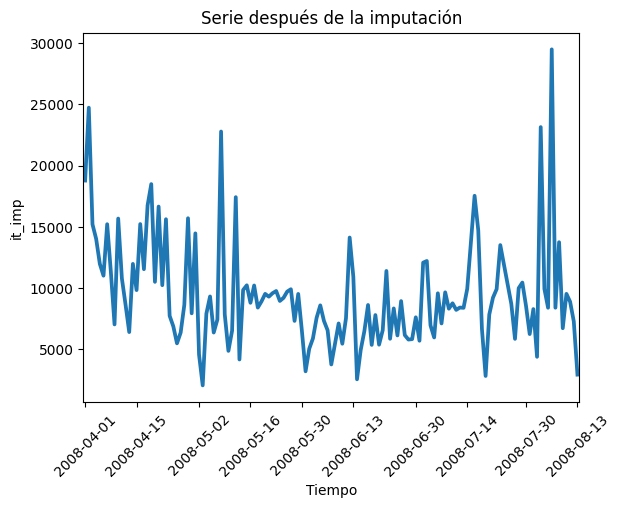

In [16]:
graficar_serie(clicks_df, obs='clicks', titulo='Serie antes de la imputación')
graficar_serie(clicks_df, obs='it_imp', titulo='Serie después de la imputación')

Vemos que esta imputación es mucho más robusta que cualquiera de las obtenidas con los métodos de imputación univariada. En lugar de imputar los datos faltantes con un valor constante, la imputación generada tiene en cuenta el comportamiento de las covariables para generar una mejor estimación.

En el caso anterior usamos la regresión lineal pero se podrían usar modelos más sofisticados, como por ejemplo Bosques Aleatorios, k-vecinos más cercanos o incluso Redes Neuronales.

## 4. Imputación con el algoritmo MICE (*Multiple Imputation by Chained Equations*)

En este caso la idea es hacer una primera estimación de los valores faltantes usando imputación univariada y luego, de forma iterativa, refinar esta estimación usando modelos de regresión como los vistos hace un momento.

Es un método más robusto que el usado en el caso anterior y permite incluso imputar múltiples variables (es decir múltiples columnas del dataset) con valores faltantes.

![](imputacion_MICE.png)

Al igual que en el método anterior, en este caso el Modelo de Regresión usado puede ser tan simple como por ejemplo la Regresión Lineal o más complejo como por ejemplo los Bosques Aleatorios.

Aunque MICE permite imputar incluso múltiples variables podemos hacer uso del método para este caso particular de *clicks_df* donde tenemos una única variable "problemática" (la columna "clicks").

Comencemos importando de "statsmodels":

- `MICEData`: para realizar la imputación usando el método MICE
- `statsmodels.api` para poder definir el modelo de regresión a usar

In [17]:
from statsmodels.imputation.mice import MICEData
import statsmodels.api as sm

Ahora almacenamos el set de datos en una variable tipo `MICEData`:

In [18]:
mice_data = MICEData(clicks_df)
mice_data.data

,precio,ubicacion,clicks,it_imp
0,43.155647,2,18784.0,18784.0
1,43.079056,1,24738.0,24738.0
2,43.842609,2,15209.0,15209.0
3,43.312376,1,14018.0,14018.0
4,43.941176,1,11974.0,11974.0
...,...,...,...,...
130,44.182033,1,6716.0,6716.0
131,43.608260,1,9523.0,9523.0
132,43.553363,1,8881.0,8881.0
133,44.500469,1,7272.0,7272.0


En esencia son los mismos datos pero este paso adicional es requerido por "statsmodels".

Ahora debemos definir los detalles de la imputación. Para ello usamos el método `set_imputer` y definimos:

- `clicks` como la variable a imputar
- `formula = 'precio + ubicacion'` para indicar que la variable *clicks* será predicha a partir de las variables precio y ubicación (`precio + ubicacion`)
- `model_class = sm.OLS` para indicarle a "statsmodels" que el modelo de regresión a usar será simplemente un modelo de regresión lineal (*OLS = ordinary least squares*).

In [19]:
mice_data.set_imputer('clicks', formula='precio + ubicacion', model_class=sm.OLS)

Y ya estamos listos para realizar la imputación. Así que usamos el método `update_all` y definimos el número de iteraciones (`n_iter`). En este caso asumiremos 10 iteraciones (entre 5 y 10 son los valores comúnmente usados):

In [20]:
mice_data.update_all(n_iter=10)

¡Y listo, ya hemos realizado la imputación usando el método MICE!

Los resultados están almacenados en la columna "clicks" del arreglo "data" de la variable "mice_data":

In [21]:
mice_data.data.isna().sum()

precio       0
ubicacion    0
clicks       0
it_imp       0
dtype: int64

Lo único que nos resta es almacenar esta imputación en una nueva columna de *clicks_df* y realizar la gráfica comparativa antes y después de la imputación:

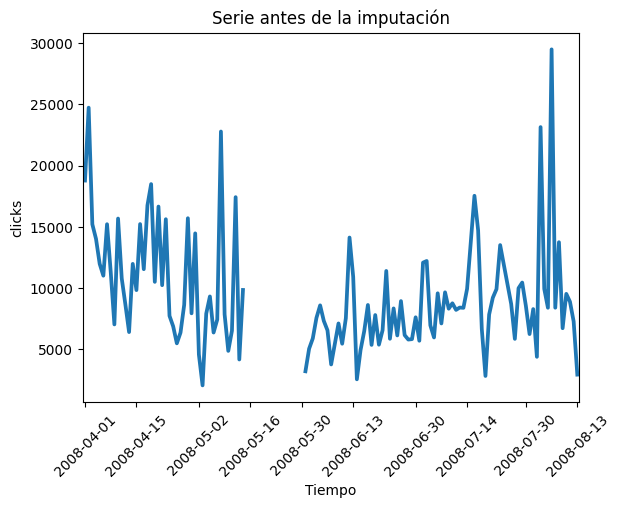

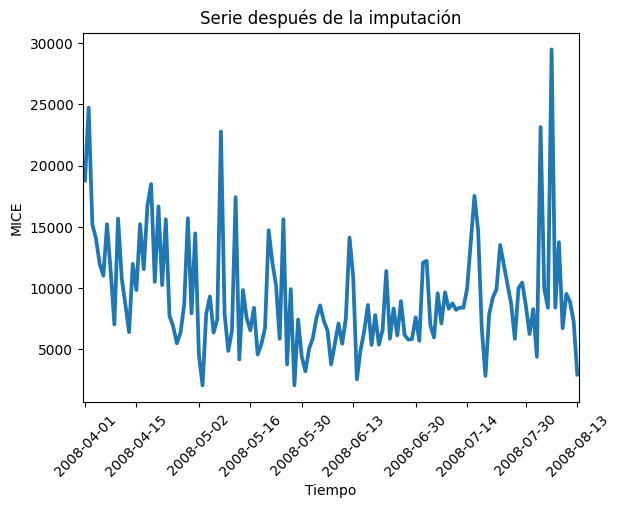

In [22]:
# Almacenar imputación MICE en la columna "MICE"
clicks_df['MICE']  = mice_data.data['clicks'].to_numpy()

# Gráficas comparativas
graficar_serie(clicks_df, obs='clicks', titulo='Serie antes de la imputación')
graficar_serie(clicks_df, obs='MICE', titulo='Serie después de la imputación')

## 5. Aspectos a tener en cuenta

Partiendo de los ejemplos anteriores podemos resumir los posibles casos de uso de cada uno de los métodos que acabamos de ver:

1. La imputación con modelos de regresión de Machine Learning se puede usar cuando tenemos una variable con datos faltantes y las demás variables están completas.
2. La imputación MICE es más robusta que la anterior y se puede usar cuando tenemos una o múltiples variables con datos faltantes.
3. Las dos imputaciones anteriores son más robustas que las imputaciones univariadas vistas en la lección anterior y se sugiere usarlas cuando tenemos grandes bloques de datos faltantes en la Serie de Tiempo.